In [1]:
# %matplotlib notebook
# from ipywidgets import *

In [2]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import pandas as pd
from collections import Counter
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

## Clustering Functions

In [3]:
def stats(data_dict, k):

    if isinstance(data_dict, dict):
        vectors = np.array(list(data_dict.values()))
    else:
        vectors = data_dict
    # keys = np.array(list(data_dict.keys()))
    
    n = vectors.shape[0]

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(vectors)

    # R^2

    inertia = kmeans.inertia_
    inertia_avg = inertia / n

    global_average = vectors.sum(axis=0) / n
    global_distance_squared_avg = np.sum(((vectors - global_average)**2)) / n

    R2 = 1 - inertia_avg / global_distance_squared_avg
    # print(f'R^2: {R2}')

    # Average importance distribution

    average_importance_dist = vectors.sum(axis=0) / n

    # Average ordered importance distribution
    # sorted_vectors = np.sort(vectors, axis=1)[:, ::-1]
    # average_ordered_importance_dist = sorted_vectors.sum(axis=1) / n

    return [R2, average_importance_dist, kmeans]#, average_ordered_importance_dist]

In [4]:
def elbow(data_dict, k_range):

    inertias_normalized = []
    for k in tqdm(k_range):
        _, __, kmeans = stats(data_dict, k)
        n = len(data_dict)
        print(n)
        inertia_normalized = kmeans.inertia_ / n
        inertias_normalized.append(inertia_normalized)
        c = Counter(kmeans.labels_)
        print(f'Cluster distribution:\n {sorted(c.items())}')

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias_normalized, '-o', label='Normalized Inertia')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Normalized Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.legend()
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()    

In [14]:
def permute_vectors(vectors_shuffled):    
    for i in range(vectors_shuffled.shape[1]):
        rand_perm = np.random.permutation(np.arange(vectors_shuffled.shape[0]))
        vectors_shuffled[:,i] = vectors_shuffled[:,i][rand_perm]
    return vectors_shuffled 

In [13]:
from sklearn.cluster import KMeans
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm

def permutation_test(data_dict, k, n_perm):

    vectors = np.array(list(data_dict.values()))

    R2s = []

    for perm in tqdm(range(n_perm)):

        vectors_shuffled = vectors.copy()
        vectors_shuffled = permute_vectors(vectors_shuffled)

        R2, _, kmeans = stats(vectors_shuffled, k=k)
        R2s.append((R2, kmeans))

    return R2s

In [6]:
def clean_data(data_dict, drop=0.05):
    data = list(data_dict.items())
    vectors = np.array([d[1] for d in data])
    dists = ((vectors - vectors.mean(axis=0))**2).sum(axis=1)
    drop = int(drop * len(vectors))
    
    partition = np.argpartition(dists,-drop)
    keep = partition[:-drop]
    drop = partition[-drop:]
    
    keepers = [data[i] for i in keep]
    drop = [data[i] for i in drop]
    return dict(keepers), dict(drop)

In [7]:
def visualize_kmeans(vectors, decomp = PCA, k = 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(vectors)
    
    decomp_ = decomp(n_components=3, random_state=42)
    vec_decomp = decomp_.fit_transform(vectors)

    ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
    colors = ['blue', 'green', 'red', 'black', 'yellow', 'purple', 'pink', 'brown']

    if k <= 8:
        scatter = ax.scatter(vec_decomp[:, 0], vec_decomp[:, 1], vec_decomp[:, 2], cmap=ListedColormap(colors[:k]), c=kmeans_labels, s=10)
        plt.colorbar(scatter, ticks=list(range(k)), label='Cluster')
    else:
        scatter = ax.scatter(vec_decomp[:, 0], vec_decomp[:, 1], vec_decomp[:, 2], c=kmeans_labels, s=10)
    
    plt.title('K-means Clusters')
    plt.show()

    silhouette_avg = silhouette_score(vectors, kmeans_labels)
    print(f'K={k}, Average Silhouette score: {silhouette_avg}\n')

    c = Counter(kmeans_labels)
    print(f'Cluster distribution:\n {sorted(c.items())}')
    
    return kmeans_labels

In [43]:
def get_groups(data_dict, kmeans):
    toks = list(vector_dict_l1.keys())
    labels = kmeans.labels_.tolist()
    groups = {}
    for tok, label in zip(toks, labels):
        if label not in groups:
            groups[label] = []
        groups[label].append(tok)
    return groups

## Testing:

In [8]:
import pandas as pd

In [9]:
vector_dict = {}
for i in range(0, 1000, 100):
    partial_vector_dict = pd.read_pickle(f"importances/importance_{i+99}.pkl")
    vector_dict.update(partial_vector_dict)

### 1st layer:

In [10]:
vector_dict_l1 = {k:v[0].numpy() for k,v in vector_dict.items()}

In [11]:
vector_dict_l1, drops_l1 = clean_data(vector_dict_l1)

 14%|█████████████▊                                                                                   | 1/7 [00:01<00:11,  1.84s/it]

950
Cluster distribution:
 [(0, 571), (1, 379)]


 29%|███████████████████████████▋                                                                     | 2/7 [00:04<00:12,  2.58s/it]

950
Cluster distribution:
 [(0, 315), (1, 115), (2, 325), (3, 195)]


 43%|█████████████████████████████████████████▌                                                       | 3/7 [00:09<00:14,  3.63s/it]

950
Cluster distribution:
 [(0, 61), (1, 177), (2, 74), (3, 81), (4, 159), (5, 184), (6, 114), (7, 100)]


 57%|███████████████████████████████████████████████████████▍                                         | 4/7 [00:16<00:14,  4.88s/it]

950
Cluster distribution:
 [(0, 126), (1, 111), (2, 12), (3, 109), (4, 17), (5, 189), (6, 81), (7, 56), (8, 62), (9, 11), (10, 70), (11, 77), (12, 1), (13, 2), (14, 25), (15, 1)]


 71%|█████████████████████████████████████████████████████████████████████▎                           | 5/7 [00:28<00:14,  7.26s/it]

950
Cluster distribution:
 [(0, 94), (1, 2), (2, 3), (3, 94), (4, 54), (5, 41), (6, 2), (7, 25), (8, 7), (9, 25), (10, 11), (11, 9), (12, 42), (13, 22), (14, 1), (15, 5), (16, 1), (17, 139), (18, 1), (19, 18), (20, 49), (21, 3), (22, 6), (23, 1), (24, 38), (25, 59), (26, 1), (27, 1), (28, 1), (29, 116), (30, 36), (31, 43)]


 86%|███████████████████████████████████████████████████████████████████████████████████▏             | 6/7 [00:50<00:12, 12.38s/it]

950
Cluster distribution:
 [(0, 1), (1, 85), (2, 5), (3, 1), (4, 2), (5, 1), (6, 30), (7, 10), (8, 49), (9, 23), (10, 14), (11, 9), (12, 2), (13, 1), (14, 1), (15, 133), (16, 16), (17, 1), (18, 1), (19, 1), (20, 37), (21, 1), (22, 1), (23, 22), (24, 1), (25, 17), (26, 1), (27, 1), (28, 1), (29, 1), (30, 45), (31, 1), (32, 37), (33, 62), (34, 1), (35, 9), (36, 19), (37, 1), (38, 12), (39, 1), (40, 39), (41, 1), (42, 85), (43, 1), (44, 3), (45, 1), (46, 1), (47, 23), (48, 1), (49, 1), (50, 1), (51, 4), (52, 1), (53, 1), (54, 35), (55, 1), (56, 1), (57, 1), (58, 2), (59, 62), (60, 1), (61, 3), (62, 23), (63, 1)]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:30<00:00, 12.98s/it]

950
Cluster distribution:
 [(0, 5), (1, 30), (2, 1), (3, 1), (4, 29), (5, 19), (6, 1), (7, 5), (8, 58), (9, 14), (10, 1), (11, 21), (12, 25), (13, 3), (14, 114), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 24), (22, 2), (23, 13), (24, 12), (25, 6), (26, 32), (27, 1), (28, 1), (29, 1), (30, 1), (31, 11), (32, 1), (33, 53), (34, 46), (35, 1), (36, 1), (37, 7), (38, 1), (39, 47), (40, 3), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 12), (61, 1), (62, 1), (63, 1), (64, 1), (65, 27), (66, 5), (67, 1), (68, 14), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 74), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 21), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), 

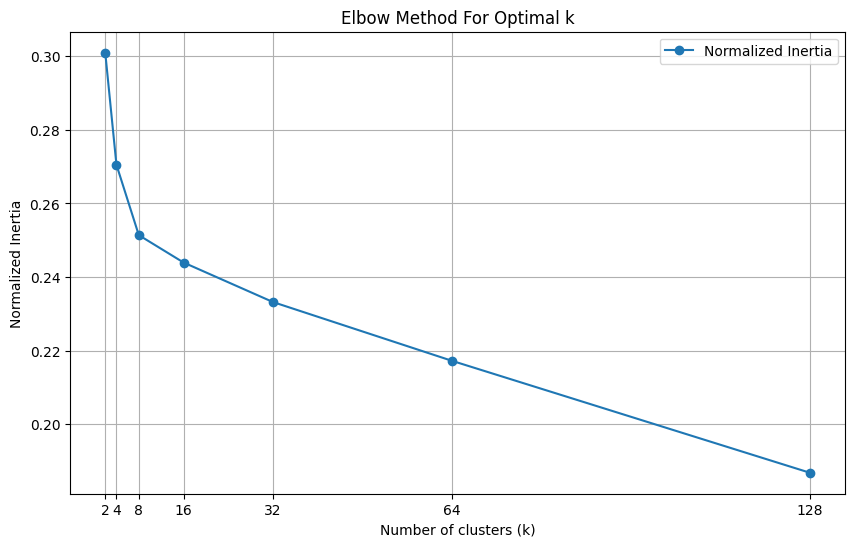

In [22]:
elbow(vector_dict_l1, k_range=[2, 4, 8, 16, 32, 64, 128])

In [17]:
np.random.seed(123)
permutation_test_results = permutation_test(vector_dict_l1, 8, 5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.79s/it]


In [28]:
permutation_test_results

[(0.07068379631753918, KMeans(n_init=10, random_state=42)),
 (0.0700121338650338, KMeans(n_init=10, random_state=42)),
 (0.07042128487470378, KMeans(n_init=10, random_state=42)),
 (0.0699325428736638, KMeans(n_init=10, random_state=42)),
 (0.06990365309675839, KMeans(n_init=10, random_state=42))]

In [19]:
l1_stats = stats(vector_dict_l1, 8)

In [20]:
l1_stats 

[0.3402839820878538,
 array([0.01588816, 0.01675987, 0.01522204, ..., 0.01960526, 0.01041118,
        0.01286184], dtype=float32),
 KMeans(n_init=10, random_state=42)]

In [12]:
test_results = np.array([test_res[0] for test_res in permutation_test_results] + [l1_stats[0]])

In [13]:
print(f"p_value: {(test_results >= l1_stats[0]).mean()}")

p_value: 0.006622516556291391


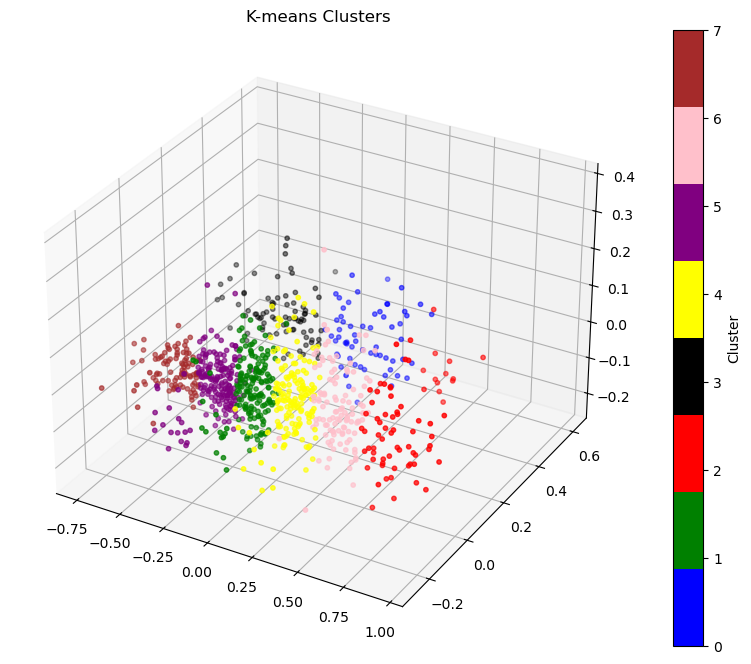

K=8, Average Silhouette score: 0.02272148908138732

Cluster distribution:
 [(0, 61), (1, 177), (2, 74), (3, 81), (4, 159), (5, 184), (6, 114), (7, 100)]


In [12]:
visualize_kmeans(np.array(list(vector_dict_l1.values())), decomp=PCA, k=8);

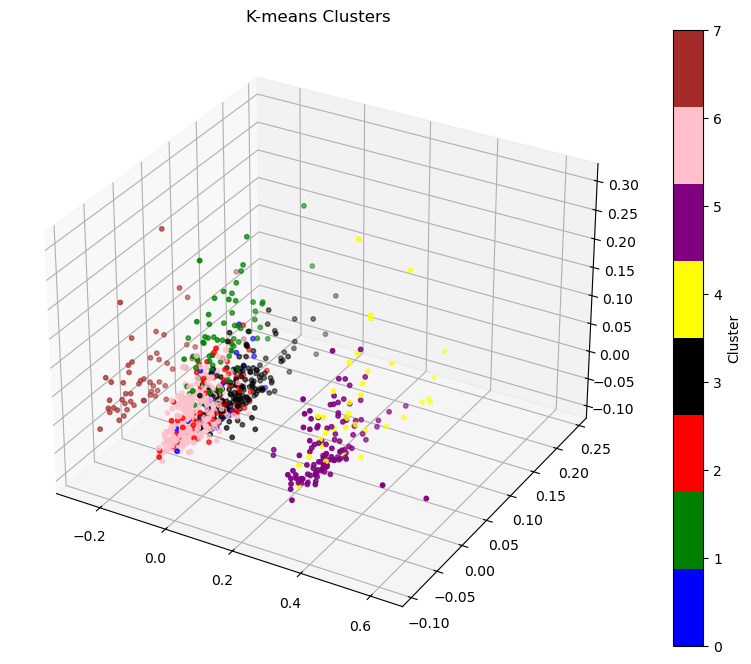

K=8, Average Silhouette score: 0.0016218972575761787

Cluster distribution:
 [(0, 29), (1, 70), (2, 90), (3, 202), (4, 37), (5, 118), (6, 351), (7, 53)]


In [16]:
visualize_kmeans(permute_vectors(np.array(list(vector_dict_l1.values())).copy()), decomp=PCA, k=8);

In [44]:
groups_l1 = get_groups(vector_dict_l1, l1_stats[-1])

In [59]:
groups_l1[3]

[(4067, ' location', 11168),
 (3451, ' career', 11230),
 (1393, ' interest', 11360),
 (1969, ' close', 11370),
 (5103, ' construction', 11415),
 (3690, ' throughout', 11601),
 (1639, 'You', 11685),
 (3352, ' plans', 11912),
 (395, 'est', 11954),
 (4673, ' learning', 11969),
 (3096, ' board', 12114),
 (3623, ' gas', 12115),
 (1775, ' seen', 12139),
 (4155, ' ensure', 12208),
 (2612, ' heart', 12219),
 (3482, ' UK', 12227),
 (1183, "'ll", 12238),
 (3403, ' conditions', 12283),
 (2756, ' price', 12320),
 (1085, ' lead', 12375),
 (1643, ' bit', 12472),
 (2067, ' started', 12497),
 (1683, ' ever', 12503),
 (2472, ' total', 12515),
 (425, 'ive', 12625),
 (1862, ' young', 12679),
 (2694, ' ability', 10990),
 (3084, ' table', 10999),
 (3503, ' etc', 11023),
 (2745, ' weeks', 11148),
 (2708, ' article', 11271),
 (1106, '....', 11368),
 (2263, ' taking', 11405),
 (2842, ' ways', 11415),
 (2793, ' lower', 11472),
 (2614, ' personal', 11502),
 (4996, ' variety', 11537),
 (1807, ' thought', 11663),

In [55]:
groups_l1[6]

[(30, '?', 124384),
 (2026, ' 50', 14012),
 (55, 'X', 15729),
 (3871, ' patients', 31876),
 (3961, ' School', 17015),
 (418, 'os', 24296),
 (860, ' 9', 23951),
 (350, ' P', 46224),
 (1877, ' low', 22558),
 (198, '\n', 1706000),
 (301, 'st', 20887),
 (1169, 'the', 19221),
 (270, 'it', 19087),
 (349, 'ol', 19021),
 (983, ' game', 18804),
 (52, 'U', 18668),
 (341, 'ation', 25606),
 (370, ' W', 26032),
 (415, 'ant', 17723),
 (90, '{', 17645),
 (2102, ' However', 17607),
 (45, 'N', 26687),
 (1760, ' done', 17235),
 (572, ' off', 28615),
 (39, 'H', 28975),
 (300, ' l', 16709),
 (587, ' been', 118018),
 (75, 'l', 30050),
 (767, ' 7', 30161),
 (583, ' per', 30330),
 (2351, ' National', 16166),
 (31, '@', 16071),
 (508, ' who', 103480),
 (618, ' when', 89935),
 (1737, ' May', 15837),
 (509, ' K', 31112),
 (65, 'b', 31346),
 (0, '!', 82976),
 (2059, ' University', 32260),
 (1634, 'ization', 13084),
 (399, ' N', 33505),
 (66, 'c', 34046),
 (689, 'ates', 13318),
 (1839, ' won', 13321),
 (261, 'on'

### 12th layer:

In [60]:
vector_dict_l12 = {k:v[1].numpy() for k,v in vector_dict.items()}

In [61]:
vector_dict_l12, dropped = clean_data(vector_dict_l12)

 14%|█████████████▊                                                                                   | 1/7 [00:03<00:21,  3.55s/it]

950
Cluster distribution:
 [(0, 382), (1, 568)]


 29%|███████████████████████████▋                                                                     | 2/7 [00:07<00:17,  3.58s/it]

950
Cluster distribution:
 [(0, 351), (1, 299), (2, 175), (3, 125)]


 43%|█████████████████████████████████████████▌                                                       | 3/7 [00:12<00:17,  4.40s/it]

950
Cluster distribution:
 [(0, 62), (1, 130), (2, 97), (3, 149), (4, 103), (5, 178), (6, 163), (7, 68)]


 57%|███████████████████████████████████████████████████████▍                                         | 4/7 [00:20<00:17,  5.90s/it]

950
Cluster distribution:
 [(0, 8), (1, 30), (2, 77), (3, 177), (4, 123), (5, 100), (6, 1), (7, 49), (8, 7), (9, 30), (10, 173), (11, 30), (12, 27), (13, 54), (14, 8), (15, 56)]


 71%|█████████████████████████████████████████████████████████████████████▎                           | 5/7 [00:33<00:16,  8.45s/it]

950
Cluster distribution:
 [(0, 1), (1, 2), (2, 112), (3, 122), (4, 28), (5, 98), (6, 27), (7, 50), (8, 53), (9, 4), (10, 22), (11, 112), (12, 3), (13, 1), (14, 4), (15, 1), (16, 79), (17, 12), (18, 31), (19, 1), (20, 40), (21, 2), (22, 1), (23, 23), (24, 1), (25, 59), (26, 11), (27, 1), (28, 41), (29, 6), (30, 1), (31, 1)]


 86%|███████████████████████████████████████████████████████████████████████████████████▏             | 6/7 [00:55<00:13, 13.04s/it]

950
Cluster distribution:
 [(0, 1), (1, 2), (2, 64), (3, 1), (4, 8), (5, 9), (6, 25), (7, 27), (8, 7), (9, 1), (10, 8), (11, 14), (12, 1), (13, 4), (14, 6), (15, 14), (16, 1), (17, 1), (18, 3), (19, 17), (20, 40), (21, 30), (22, 9), (23, 47), (24, 10), (25, 9), (26, 72), (27, 14), (28, 1), (29, 65), (30, 1), (31, 44), (32, 1), (33, 1), (34, 30), (35, 1), (36, 1), (37, 2), (38, 25), (39, 15), (40, 1), (41, 2), (42, 25), (43, 47), (44, 50), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 13), (53, 1), (54, 1), (55, 1), (56, 6), (57, 3), (58, 44), (59, 5), (60, 44), (61, 1), (62, 1), (63, 65)]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:36<00:00, 13.83s/it]

950
Cluster distribution:
 [(0, 1), (1, 4), (2, 3), (3, 1), (4, 2), (5, 1), (6, 7), (7, 56), (8, 6), (9, 38), (10, 3), (11, 13), (12, 13), (13, 10), (14, 3), (15, 1), (16, 3), (17, 6), (18, 3), (19, 16), (20, 2), (21, 12), (22, 3), (23, 1), (24, 2), (25, 1), (26, 1), (27, 7), (28, 5), (29, 85), (30, 38), (31, 1), (32, 8), (33, 18), (34, 1), (35, 2), (36, 1), (37, 8), (38, 148), (39, 2), (40, 1), (41, 1), (42, 16), (43, 1), (44, 1), (45, 2), (46, 1), (47, 7), (48, 1), (49, 1), (50, 1), (51, 24), (52, 2), (53, 2), (54, 1), (55, 1), (56, 30), (57, 8), (58, 1), (59, 7), (60, 1), (61, 72), (62, 1), (63, 1), (64, 4), (65, 1), (66, 8), (67, 2), (68, 14), (69, 1), (70, 15), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 14), (78, 2), (79, 4), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 47), (93, 1), (94, 1), (95, 5), (96, 1), (97, 1), (98, 13), (99, 1), (100, 1), (101, 23), (102, 1), (103, 1), (104, 1), (105, 1), 

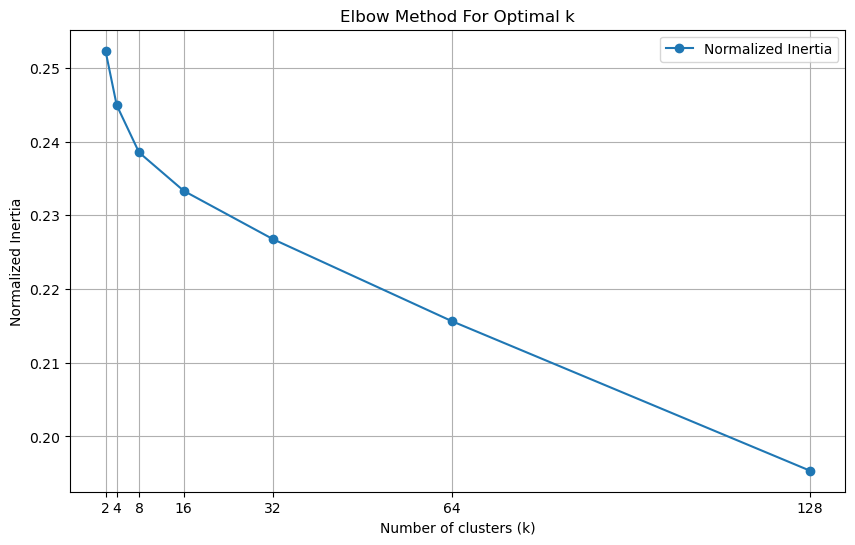

In [62]:
elbow(vector_dict_l12, k_range=[2, 4, 8, 16, 32, 64, 128])

In [63]:
np.random.seed(123)
permutation_test_results_l12 = permutation_test(vector_dict_l12, 8, 5)
permutation_test_results_l12

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.93s/it]


[(0.014643134756592624, KMeans(n_init=10, random_state=42)),
 (0.013744231412660235, KMeans(n_init=10, random_state=42)),
 (0.01470821685356205, KMeans(n_init=10, random_state=42)),
 (0.01494643564218645, KMeans(n_init=10, random_state=42)),
 (0.015042548076430351, KMeans(n_init=10, random_state=42))]

In [64]:
l12_stats = stats(vector_dict_l12, 8)

In [65]:
l12_stats 

[0.1140785174445722,
 array([0.01356908, 0.02429276, 0.01353618, ..., 0.01702303, 0.02207237,
        0.01360197], dtype=float32),
 KMeans(n_init=10, random_state=42)]

In [66]:
test_results_l12 = np.array([test_res[0] for test_res in permutation_test_results_l12] + [l12_stats[0]])

In [67]:
# print(f"p_value: {(test_results_l12 >= l12_stats[0]).mean()}")

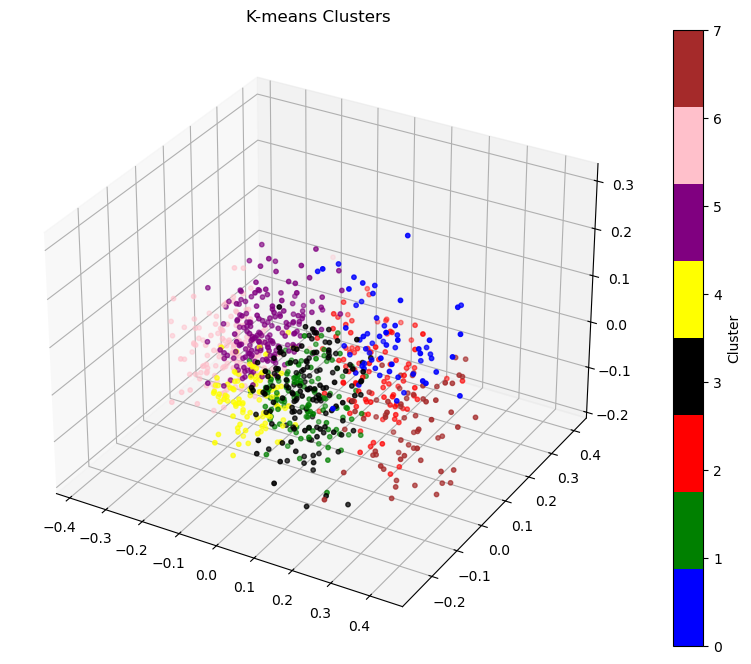

K=8, Average Silhouette score: 0.0033951056799688484

Cluster distribution:
 [(0, 62), (1, 130), (2, 97), (3, 149), (4, 103), (5, 178), (6, 163), (7, 68)]


In [77]:
visualize_kmeans(np.array(list(vector_dict_l12.values())), decomp=PCA, k=8);

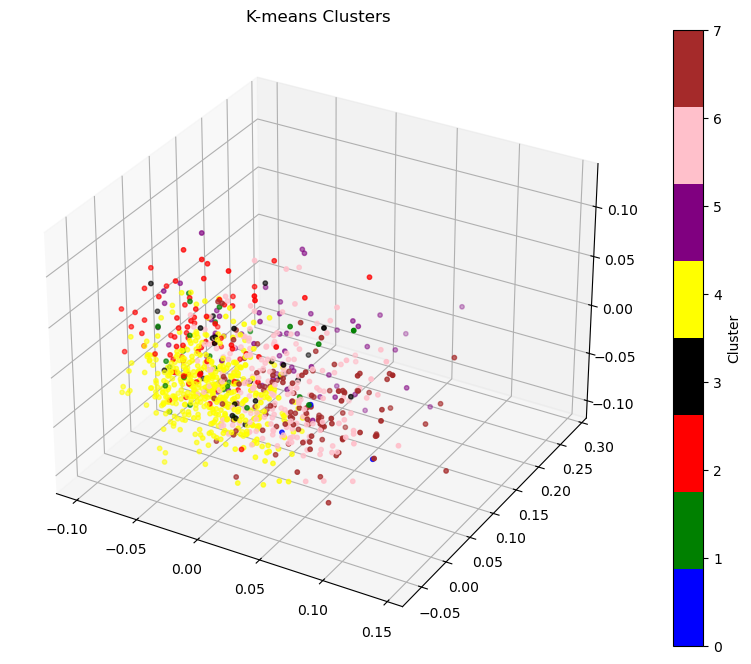

K=8, Average Silhouette score: 0.0002971902742556706

Cluster distribution:
 [(0, 3), (1, 27), (2, 81), (3, 28), (4, 430), (5, 61), (6, 204), (7, 116)]


In [80]:
visualize_kmeans(permute_vectors(np.array(list(vector_dict_l12.values()))), decomp=PCA, k=8);

### 24th layer:

In [68]:
vector_dict_l24 = {k:v[2].numpy() for k,v in vector_dict.items()}

In [69]:
vector_dict_l24, dropped = clean_data(vector_dict_l24)

 14%|█████████████▊                                                                                   | 1/7 [00:02<00:14,  2.38s/it]

950
Cluster distribution:
 [(0, 332), (1, 618)]


 29%|███████████████████████████▋                                                                     | 2/7 [00:07<00:18,  3.72s/it]

950
Cluster distribution:
 [(0, 326), (1, 109), (2, 112), (3, 403)]


 43%|█████████████████████████████████████████▌                                                       | 3/7 [00:11<00:17,  4.28s/it]

950
Cluster distribution:
 [(0, 224), (1, 86), (2, 109), (3, 52), (4, 197), (5, 84), (6, 50), (7, 148)]


 57%|███████████████████████████████████████████████████████▍                                         | 4/7 [00:20<00:17,  5.82s/it]

950
Cluster distribution:
 [(0, 32), (1, 90), (2, 98), (3, 60), (4, 154), (5, 23), (6, 23), (7, 3), (8, 36), (9, 71), (10, 33), (11, 71), (12, 18), (13, 44), (14, 123), (15, 71)]


 71%|█████████████████████████████████████████████████████████████████████▎                           | 5/7 [00:31<00:15,  7.89s/it]

950
Cluster distribution:
 [(0, 117), (1, 4), (2, 56), (3, 1), (4, 49), (5, 45), (6, 4), (7, 7), (8, 31), (9, 3), (10, 68), (11, 4), (12, 32), (13, 56), (14, 1), (15, 15), (16, 15), (17, 37), (18, 14), (19, 96), (20, 44), (21, 2), (22, 2), (23, 134), (24, 2), (25, 2), (26, 1), (27, 32), (28, 49), (29, 23), (30, 3), (31, 1)]


 86%|███████████████████████████████████████████████████████████████████████████████████▏             | 6/7 [00:52<00:12, 12.42s/it]

950
Cluster distribution:
 [(0, 5), (1, 1), (2, 12), (3, 11), (4, 2), (5, 6), (6, 60), (7, 34), (8, 11), (9, 43), (10, 6), (11, 21), (12, 14), (13, 4), (14, 2), (15, 22), (16, 9), (17, 10), (18, 1), (19, 9), (20, 7), (21, 5), (22, 34), (23, 37), (24, 5), (25, 11), (26, 59), (27, 2), (28, 108), (29, 1), (30, 6), (31, 58), (32, 1), (33, 1), (34, 109), (35, 1), (36, 28), (37, 1), (38, 1), (39, 1), (40, 4), (41, 2), (42, 2), (43, 10), (44, 2), (45, 3), (46, 1), (47, 31), (48, 1), (49, 42), (50, 3), (51, 3), (52, 1), (53, 1), (54, 5), (55, 2), (56, 1), (57, 1), (58, 23), (59, 1), (60, 1), (61, 1), (62, 1), (63, 49)]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:34<00:00, 13.51s/it]

950
Cluster distribution:
 [(0, 1), (1, 24), (2, 5), (3, 87), (4, 2), (5, 2), (6, 6), (7, 3), (8, 32), (9, 2), (10, 60), (11, 37), (12, 4), (13, 12), (14, 1), (15, 6), (16, 10), (17, 3), (18, 1), (19, 14), (20, 1), (21, 8), (22, 6), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 6), (29, 13), (30, 2), (31, 10), (32, 6), (33, 9), (34, 1), (35, 1), (36, 13), (37, 21), (38, 1), (39, 1), (40, 2), (41, 26), (42, 1), (43, 16), (44, 4), (45, 12), (46, 1), (47, 1), (48, 1), (49, 20), (50, 5), (51, 8), (52, 86), (53, 2), (54, 1), (55, 27), (56, 33), (57, 1), (58, 1), (59, 1), (60, 8), (61, 2), (62, 29), (63, 2), (64, 1), (65, 5), (66, 1), (67, 1), (68, 3), (69, 1), (70, 1), (71, 1), (72, 1), (73, 4), (74, 1), (75, 1), (76, 1), (77, 54), (78, 1), (79, 7), (80, 1), (81, 9), (82, 2), (83, 15), (84, 2), (85, 1), (86, 1), (87, 1), (88, 4), (89, 3), (90, 1), (91, 2), (92, 9), (93, 29), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 3), (100, 1), (101, 6), (102, 27), (103, 2), (104, 1), (105, 1)

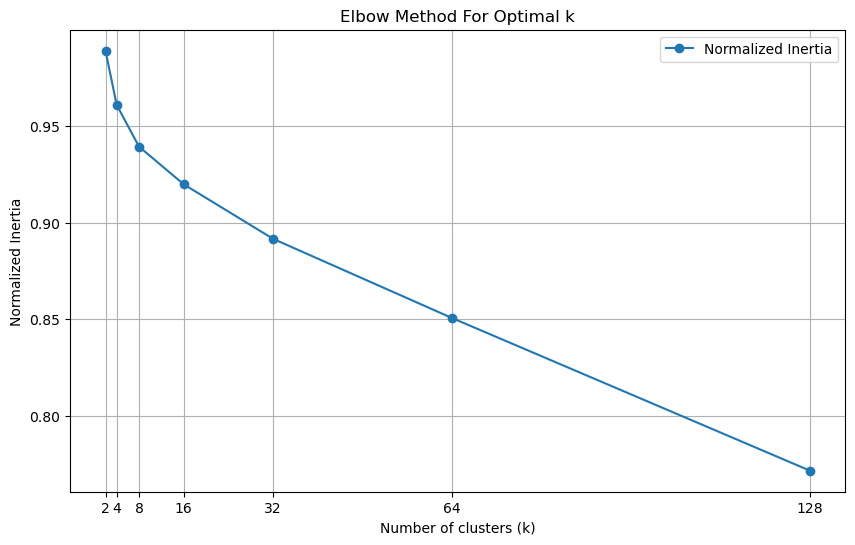

In [70]:
elbow(vector_dict_l24, k_range=[2, 4, 8, 16, 32, 64, 128])

In [71]:
np.random.seed(123)
permutation_test_results_l24 = permutation_test(vector_dict_l24, 8, 5)
permutation_test_results_l24

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:24<00:00,  4.82s/it]


[(0.01603355457918132, KMeans(n_init=10, random_state=42)),
 (0.015589536609286081, KMeans(n_init=10, random_state=42)),
 (0.015253589782929566, KMeans(n_init=10, random_state=42)),
 (0.015284748095429457, KMeans(n_init=10, random_state=42)),
 (0.01591758056109771, KMeans(n_init=10, random_state=42))]

In [72]:
l24_stats = stats(vector_dict_l24, 8)

In [73]:
l24_stats 

[0.09800365212960593,
 array([0.01186678, 0.0145148 , 0.01893092, ..., 0.02541118, 0.01436678,
        0.01481908], dtype=float32),
 KMeans(n_init=10, random_state=42)]

In [ ]:
# test_results_l24 = np.array([test_res[0] for test_res in permutation_test_results_l24] + [l24_stats[0]])

In [ ]:
# print(f"p_value: {(test_results_l24 >= l24_stats[0]).mean()}")

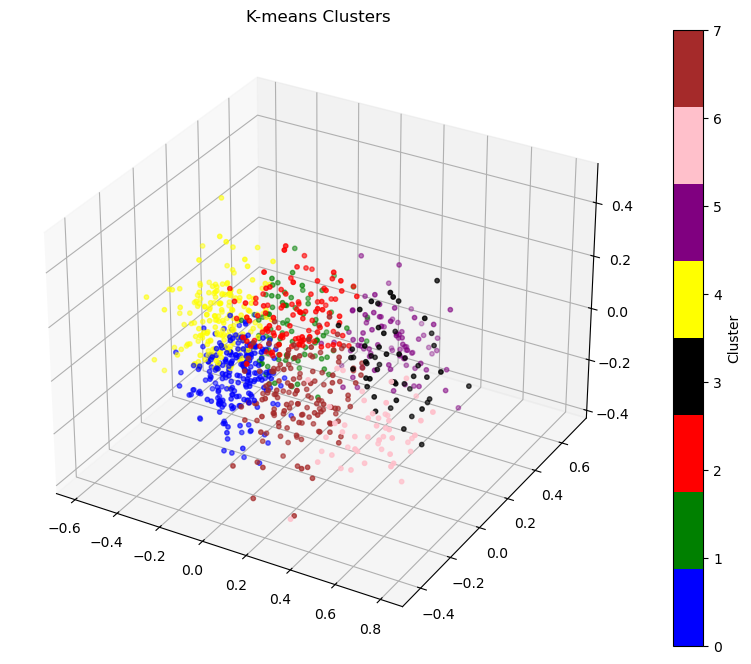

K=8, Average Silhouette score: 0.005717905817360248

Cluster distribution:
 [(0, 224), (1, 86), (2, 109), (3, 52), (4, 197), (5, 84), (6, 50), (7, 148)]


In [78]:
visualize_kmeans(np.array(list(vector_dict_l24.values())), decomp=PCA, k=8);

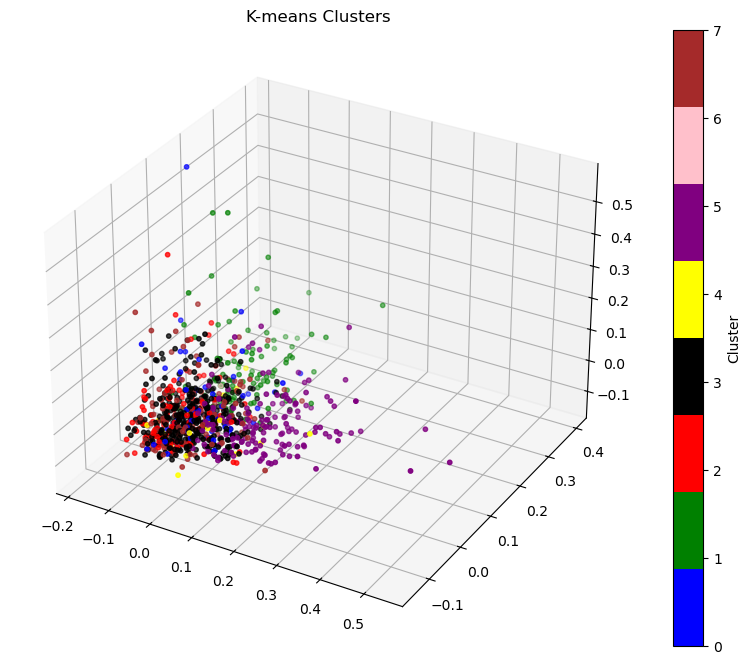

K=8, Average Silhouette score: 0.0003703242181464762

Cluster distribution:
 [(0, 55), (1, 102), (2, 111), (3, 375), (4, 20), (5, 158), (6, 1), (7, 128)]


In [79]:
visualize_kmeans(permute_vectors(np.array(list(vector_dict_l24.values()))), decomp=PCA, k=8);

## Random data stuff

In [5]:
# Generate random data

n_data = 1000
vec_dim = 819

random_data_dict = {str(i): np.random.rand(vec_dim) for i in range(n_data)}

# Verify the size of the dictionary and the dimensionality of a sample vector
dict_size = len(random_data_dict)
sample_vector_dimension = random_data_dict['0'].shape[0]

dict_size, sample_vector_dimension

(1000, 819)

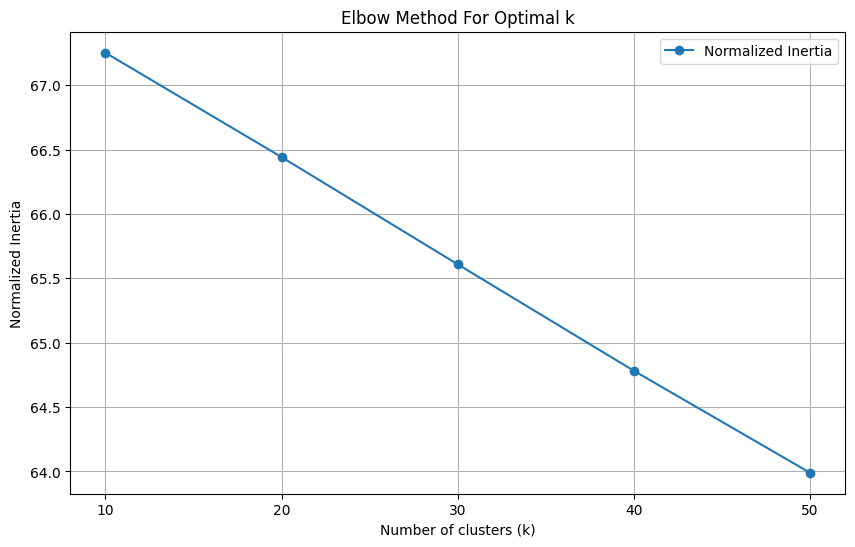

In [9]:
# Test run elbow on random data

k_list = np.arange(10, 51, 10)

elbow(random_data_dict, k_list)